<center> <h3> MNIST neural network from scratch </h3></center>

#### Fully Connected Layer (Linear Layer)

In [1]:
import numpy as np 

class Linear():
    def __init__(self, in_size, out_size):
        self.W = np.random.randn(in_size, out_size) * 0.01
        self.b = np.zeros((1, out_size))
        self.params = [self.W, self.b]
        self.gradW = None
        self.gradB = None
        self.gradInput = None        

    def forward(self, X):
        self.X = X
        self.output = np.dot(X, self.W) + self.b
        return self.output

    def backward(self, nextgrad):
        self.gradW = np.dot(self.X.T, nextgrad)
        self.gradB = np.sum(nextgrad, axis=0)
        self.gradInput = np.dot(nextgrad, self.W.T)
        return self.gradInput, [self.gradW, self.gradB]

#### Rectified Linear Activation Layer (ReLU)


In [2]:
class ReLU():
    def __init__(self):
        self.params = []
        self.gradInput = None

    def forward(self, X):
        self.output = np.maximum(X, 0)
        return self.output

    def backward(self, nextgrad):
        self.gradInput = nextgrad.copy()
        self.gradInput[self.output <=0] = 0
        return self.gradInput, []

####  softmax function

In [3]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

#### Cross Entropy Loss

In [4]:
class CrossEntropy:
    def forward(self, X, y):
        self.m = y.shape[0]
        self.p = softmax(X)
        cross_entropy = -np.log(self.p[range(self.m), y])
        loss = cross_entropy[0] / self.m
        return loss
    
    def backward(self, X, y):
        y_idx = y.argmax()        
        grad = softmax(X)
        grad[range(self.m), y] -= 1
        grad /= self.m
        return grad

#### Loading the MNIST dataset

In [5]:
from keras.datasets import mnist
from keras.utils import np_utils


(train_features, train_targets), (test_features, test_targets) = mnist.load_data()


train_features = train_features.reshape(60000, 784)
print(train_features.shape)
test_features = test_features.reshape(10000, 784)
print(test_features.shape)


# # normalize inputs from 0-255 to 0-1
train_features = train_features / 255.0
test_features = test_features / 255.0

print(train_targets.shape)
print(test_targets.shape)

X_train = train_features
y_train = train_targets

X_val = test_features
y_val = test_targets


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

(60000, 784)
(10000, 784)
(60000,)
(10000,)


### visualizing the first 10 images in the dataset and their labels


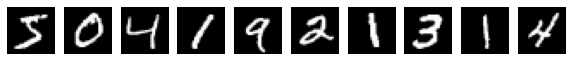

label for each of the above image: [5 0 4 1 9 2 1 3 1 4]


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 1))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i].reshape(28, 28), cmap="gray")
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

#### Neural Network

In [7]:
class NeuralNetwork():
    def __init__(self, lossfunc=CrossEntropy()):
        self.params = []
        self.layers = []
        self.loss_func = lossfunc
        self.grads = []
        
    def add_layer(self, layer):
        self.layers.append(layer)
        self.params.append(layer.params)

    def forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X
    
    def backward(self, nextgrad):
        self.clear_grad_param()
        for layer in reversed(self.layers):
            nextgrad, grad = layer.backward(nextgrad)
            self.grads.append(grad)
        return self.grads
    
    def train_step(self, X, y):
        out = self.forward(X)
        loss = self.loss_func.forward(out,y)
        nextgrad = self.loss_func.backward(out,y)
        grads = self.backward(nextgrad)
        return loss, grads
    
    def predict(self, X):
        X = self.forward(X)
        return np.argmax(X, axis=1)
    
    def predict_scores(self, X):
        X = self.forward(X)
        return X
    
    def clear_grad_param(self):
        self.grads = []

#### update function (SGD with momentum) to change the parameters

In [8]:
def update_params(velocity, params, grads, learning_rate=0.01, mu=0.9):
    for v, p, g, in zip(velocity, params, reversed(grads)):
        for i in range(len(g)):
            v[i] = mu * v[i] + learning_rate * g[i]
            p[i] -= v[i]

#### Defining a function which gives us the minibatches (both the datapoint and the corresponding label)

In [9]:
def minibatch(X, y, minibatch_size):
    n = X.shape[0]
    minibatches = []
    permutation = np.random.permutation(X.shape[0])
    X = X[permutation]
    y = y[permutation]
    
    for i in range(0, n , minibatch_size):
        X_batch = X[i:i + minibatch_size, :]
        y_batch = y[i:i + minibatch_size, ]
        minibatches.append((X_batch, y_batch))
        
    return minibatches

#### The traning loop

In [10]:
def train(net, X_train, y_train, minibatch_size, epoch, learning_rate, mu=0.9, X_val=None, y_val=None):
    val_loss_epoch = []
    minibatches = minibatch(X_train, y_train, minibatch_size)
    minibatches_val = minibatch(X_val, y_val, minibatch_size)

    
    for i in range(epoch):
        loss_batch = []
        val_loss_batch = []
        velocity = []
        for param_layer in net.params:
            p = [np.zeros_like(param) for param in list(param_layer)]
            velocity.append(p)
            
        # iterate over mini batches
        for X_mini, y_mini in minibatches:
            loss, grads = net.train_step(X_mini, y_mini)
            loss_batch.append(loss)
            update_params(velocity, net.params, grads, learning_rate=learning_rate, mu=mu)

        for X_mini_val, y_mini_val in minibatches_val:
            val_loss, _ = net.train_step(X_mini, y_mini)
            val_loss_batch.append(val_loss)
        
        # accuracy of model at end of epoch after all mini batch updates
        m_train = X_train.shape[0]
        m_val = X_val.shape[0]
        y_train_pred = np.array([], dtype="int64")
        y_val_pred = np.array([], dtype="int64")
        y_train1 = []
        y_vall = []
        for i in range(0, m_train, minibatch_size):
            X_tr = X_train[i:i + minibatch_size, : ]
            y_tr = y_train[i:i + minibatch_size,]
            y_train1 = np.append(y_train1, y_tr)
            y_train_pred = np.append(y_train_pred, net.predict(X_tr))

        for i in range(0, m_val, minibatch_size):
            X_va = X_val[i:i + minibatch_size, : ]
            y_va = y_val[i:i + minibatch_size,]
            y_vall = np.append(y_vall, y_va)
            y_val_pred = np.append(y_val_pred, net.predict(X_va))
            
        train_acc = check_accuracy(y_train1, y_train_pred)
        val_acc = check_accuracy(y_vall, y_val_pred)

        mean_train_loss = sum(loss_batch) / float(len(loss_batch))
        mean_val_loss = sum(val_loss_batch) / float(len(val_loss_batch))
        
        val_loss_epoch.append(mean_val_loss)
        print("Loss = {0} | Training Accuracy = {1} | Val Loss = {2} | Val Accuracy = {3}".format(mean_train_loss, train_acc, mean_val_loss, val_acc))
    return net

#### Checking the accuracy of the model 

In [11]:
def check_accuracy(y_true, y_pred):
    return np.mean(y_pred == y_true)

#### Invoking all that we have created until now

In [12]:
from random import shuffle

#input size
input_dim = X_train.shape[1]

# hyperparameters
iterations = 10
learning_rate = 0.1
hidden_nodes = 32
output_nodes = 10

# define neural net
nn = NeuralNetwork()
nn.add_layer(Linear(input_dim, hidden_nodes))
nn.add_layer(ReLU())
nn.add_layer(Linear(hidden_nodes, output_nodes))

nn = train(nn, X_train , y_train, minibatch_size=200, epoch=10, \
           learning_rate=learning_rate, X_val=X_val, y_val=y_val)

Loss = 0.002710377483760765 | Training Accuracy = 0.93705 | Val Loss = 0.0004635319139753152 | Val Accuracy = 0.9365
Loss = 0.001156379393900452 | Training Accuracy = 0.9483833333333334 | Val Loss = 0.0004368367854815518 | Val Accuracy = 0.9424
Loss = 0.0009701091476352756 | Training Accuracy = 0.9544166666666667 | Val Loss = 0.0004584104215864876 | Val Accuracy = 0.9465
Loss = 0.0008503662447737968 | Training Accuracy = 0.9626833333333333 | Val Loss = 0.00012489660228541871 | Val Accuracy = 0.953
Loss = 0.0007788076710683093 | Training Accuracy = 0.9699333333333333 | Val Loss = 5.235870934094686e-05 | Val Accuracy = 0.961
Loss = 0.0007281564251072265 | Training Accuracy = 0.97335 | Val Loss = 2.1700099882621626e-05 | Val Accuracy = 0.9642
Loss = 0.0007054412020649493 | Training Accuracy = 0.9752333333333333 | Val Loss = 7.727637371695584e-06 | Val Accuracy = 0.9653
Loss = 0.0006739083478127391 | Training Accuracy = 0.97705 | Val Loss = 5.907040533116347e-06 | Val Accuracy = 0.9645
Los

#### fprop a single image and showing its prediction

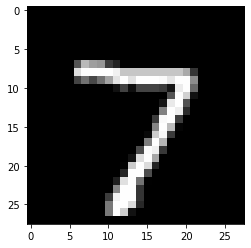

In [13]:
plt.imshow(X_val[0].reshape(28,28), cmap='gray')

In [14]:
# Predict Scores for each class
prediction = nn.predict_scores(X_val[0])[0]

In [15]:
print ("Scores")
print (prediction)

Scores
[ -5.27862615  -3.4524256    6.11980505   6.2531161  -12.11442138
   0.24033365 -15.94062583  18.29822234   1.89630488   3.95292247]


In [16]:
np.argmax(prediction)

7

In [17]:
predict_class = nn.predict(X_val[0])[0]
predict_class

7

In [18]:
# Original class
y_val[0]

7